# University of Aberdeen

## Applied AI (CS5079)

### Assessment 1 Task 3 - Reinforcement Learning by mixing Screen and RAM

---


## Imports

In [ ]:
# OpenAI has preprocessing modules in their baselines repository 
# such as FrameStack, NoopResetEnv, episode_life, etc.
# To import those we first need to install the OpenAI baseline package
# via running this code cell.
!pip install git+https://github.com/openai/baselines.git

In [2]:
# Seed value used for achieving reproducibility
SEED_VALUE = 1337

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
# For handling files
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISM'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(SEED_VALUE)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(SEED_VALUE)

# https://github.com/openai/baselines
from baselines.common.atari_wrappers import make_atari, wrap_deepmind, NoopResetEnv, FrameStack

# For plotting graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# OpenAI Gym
import gym

# The frame stack size
FRAME_STACK_SIZE = 5

# Make the Atari games and their environment assign it to
# a variable for later use (RL of the DDQN agent).
env = gym.make("Asterix-v0")
env_ram = gym.make("Asterix-ram-v0")

# Preprocess the environments (downsampling to 84x84 and
# scaling the input image pixels of the game)
env = wrap_deepmind(env, frame_stack=False, scale=True, clip_rewards=False, episode_life=False)

# Stack the input image frames by FRAME_STACK_SIZE
env = FrameStack(env, FRAME_STACK_SIZE)

# Stack the RAM states by FRAME_STACK_SIZE
env_ram = FrameStack(env_ram, FRAME_STACK_SIZE)

# Seed the Atari game environments
env.seed(SEED_VALUE), env_ram.seed(SEED_VALUE)

([1337, 17452119], [1337, 17452119])

In [3]:
# Print the observation and action spaces, and the Atari 
# game action space and their names (meanings)
print("Observation spaces:")
print(f"\tImage: {env.observation_space.shape}\n\tRAM: {env_ram.observation_space.shape}")
print("Action space:", env.action_space)
print("Possible actions:", env.unwrapped.get_action_meanings())

Observation spaces:
	Image: (84, 84, 5)
	RAM: (640,)
Action space: Discrete(9)
Possible actions: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


## Task 3.1

For architecture, refer to report appendix.

In [4]:
# Import the garbage collector package
import gc

def reset_random_seeds():
    """Reset the random number generator seed to achieve full reproducibility 
    even when running the script on GPU
    """
    
    # Set the environment determinism to guarantee
    # reproducibility of the results
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISM'] = '1'
    os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    random.seed(SEED_VALUE)
    
    # Perform garbage collection
    gc.collect()
    print("Random number generator seed reset!")  # optional

### Defining global variable and importing packages for training the models

In [6]:
def normalise(ram, scale=255):
    """Normalise the RAM state inputs to be in the range [0, 1].
    """
    return ram/scale

In [7]:
# Import the Keras layer used for building our DDQN models
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D,\
MaxPool2D, Dropout, BatchNormalization, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeUniform

# Get the image and RAM input shapes
# for the DDQN models (game environment observation space)
IMG_INPUT_SHAPE = env.observation_space.shape
RAM_INPUT_SHAPE = env_ram.observation_space.shape

# Get the output shape for the DDQN models
NUM_ACTIONS = env.action_space.n

# Set the batch size
BATCH_SIZE = 32

# Set the DDQN agent memory size.
# We use a relatively small value due to assessment time constraints
# and also to provide easier reproducibility. ===================================
MEMORY_SIZE = 25000

# Define the exploration steps of the DDQN agent.
# We do not train the model during these first steps.
EXPLORATION_STEPS = 20000

# Define the learning rate to be used for the model
# gradient descent optimisation method (Adam as opposed to RMSprop) WHY ADAM??===============================
LEARNING_RATE = 0.00025

In [8]:
class SumTree:
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an optimisation experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/rlcode/per
    Args:
        capacity (int): size of the sum tree
    """
    # The data pointer class variable
    write = 0

    def __init__(self, capacity):
        """Initialize the tree with all nodes and data with values set to 0.
        """
        # Number of leaf nodes (final nodes) that contains experiences
        self.capacity = capacity
        
        # Generate the tree with all nodes values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema above
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)
        
        # Store the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)

    def _propagate(self, idx, change):
        """Recursively propagate a given child node change through the sum tree.
        """
        
        # Get the parent node index
        parent = (idx - 1) // 2
        
        # Apply the child node change to the parent node
        self.tree[parent] += change
        
        # Do this until the root node is reached
        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        """Return a leaf node (priority) index for the current experience (observation)
        """
        
        # Get the left and right child node indexes
        # for the current sample
        left = 2 * idx + 1
        right = left + 1
        
        # Return the index itself if the 
        # left child index is greater than the 
        # capacity of the sum tree
        if left >= len(self.tree):
            return idx
        
        # Start recursion
        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        """Return the root node (total sum of the experience priority values).
        """
        return self.tree[0]

    def add(self, p, data):
        """Add the experience and its priority score (as a leaf) to the sum tree.
        """
        # Get the tree index for the experience (observation)
        idx = self.write + self.capacity - 1
        
        # Update the sum tree data
        self.data[self.write] = data
        
        # Update the sum tree probability values
        self.update(idx, p)
        
        # Increment the data pointer
        self.write += 1
        
        # If over the capacity, go back to first index (we overwrite)
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        """Update the leaf priority score and propagate the change through tree.
        """
        # Change = new priority score - former priority score
        change = p - self.tree[idx]
        self.tree[idx] = p
        
        # Propagate the change through tree
        self._propagate(idx, change)

    def get(self, s):
        """Return the leaf index, priority value and its associated experience (observation).
        """
        # Get the leaf index
        idx = self._retrieve(0, s)
        
        # Get the experience (observation) index
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])
    

#-------------------- MEMORY --------------------------
class Memory:
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an optimisation experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/rlcode/per
    
    Args:
        capacity (int): size of the sum tree
    """
    # Hyperparameter to avoid assigning 0 probability to experiences
    e = 0.01
    
    # Hyperparameter to make a trade-off between random sampling and taking a
    # a high priority experience (observation)
    a = 0.6

    def __init__(self, capacity):
        """Initialise the sum tree with the given capacity.
        """
        self.tree = SumTree(capacity)

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        """Store a new experience in the tree along with its corresponding priority value.
        """
        # Get the priority from the experience (observation) error
        p = self._getPriority(error)
        
        # Store the priority and the experience (observation)
        self.tree.add(p, sample) 

    def sample(self, n):
        """Sample a n-sized batch of priority index and observation pair.
        """
        # Create a list to hold the batch pairs
        batch = []
        
        # Calculate and store the priority segment
        segment = self.tree.total() / n
        
        # Populate the batch list
        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append( (idx, data) )

        return batch

    def update(self, idx, error):
        """Update the sum tree leaves (priorities).
        """
        # Get the priority from the experience (observation) error
        p = self._getPriority(error)
        
        # Update the sum tree probability values
        self.tree.update(idx, p)

In [9]:
# Import the math Python package
import math

# Minimum and maximum epsilon value constants
MAX_EPSILON = 1
MIN_EPSILON = 0.1

# Constant that determines the speed of the epsilon decay
LAMBDA = - math.log(0.01) / EXPLORATION_STEPS 

class DDQNAgent():
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an DDQ Network and Agent experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/jaromiru/AI-blog
    
    Args:
        lr (float): learning rate of the network
    """
    steps = 0
    
    def __init__(self, lr=LEARNING_RATE):
        """Initialise the agent and the online and target DDQNs for the environment.
        """
        # The DDQN agent learning rate attribute
        # used for the Adam optimiser when building 
        # our model architecture.
        self.lr = lr
        
        # DDQN agent memory represented by a SumTree class instance
        # (faster batch sampling, thus, better runtime performance)
        self.memory = Memory(MEMORY_SIZE)
        
        # Set the initial DDQN models loss value to be +inf
        self.loss_val = np.inf
        self.action_space = NUM_ACTIONS
        
        # Disable eager execution which boosts runtime
        # Eager execution is generally used for debugging purposes
        tf.compat.v1.disable_eager_execution()
        self.discount_rate = 0.99

        # Create the two networks for predicting the actions
        
        # The first model makes the predictions for Q-values 
        # which are used to make a action.
        self.online = self.q_network()
        
        # Build a target model for the prediction of future
        # rewards. The weights of a target model get updated 
        # every 10,000 steps thus when the loss between the 
        # Q-values is calculated the target Q-value is stable.
        self.target = self.q_network()

        #The "target" DNN will take the values of the "online" DNN
        self.update_target()


    def q_network(self, filters_1=32, filters_2=64, filters_3=64):
        """Define and return the mixed (image frame + RAM state) input model architecture. 
        We shift from Sequential configuration to a functional one. This approach is used 
        when handling models with non-linear topology, shared layers, multiple inputs/outputs.
        """
        # Ensure reproducibility of the results
        # by resetting the random seeds
        reset_random_seeds()

        # Build the model
        # Define the kernel initialiser. We adopt the He uniform
        # variance scaling initialiser for improved training stability.
        kernel_init = HeUniform()
        
        # Define the RAM input layer
        img_input = Input(shape=IMG_INPUT_SHAPE)
        
        # Set the Conv2D layers
        conv_lyr = Conv2D(filters_1, kernel_size=8, padding="same", strides=4, activation='relu', kernel_initializer=kernel_init)(img_input)
        conv_lyr = Conv2D(filters_2, kernel_size=4, padding="same", strides=2, activation='relu', kernel_initializer=kernel_init)(conv_lyr)
        conv_lyr = Conv2D(filters_3, kernel_size=3, padding="same", strides=1, activation='relu', kernel_initializer=kernel_init)(conv_lyr)
        flatten_lyr = Flatten()(conv_lyr)
        
        # Define the RAM input layer
        ram_input = Input(shape=RAM_INPUT_SHAPE)
        
        # Merge the Conv2D and Dense layer outputs into a single large vector via concatenation
        concat_lyr = concatenate([flatten_lyr, ram_input])
        
        # We pass RAM environment states as the inputs to our Dense layers 
        dense_lyr = Dense(512, activation='relu', kernel_initializer=kernel_init)(concat_lyr)
        dense_lyr = Dense(256, activation='relu', kernel_initializer=kernel_init)(dense_lyr)
        
        # Pass the concatenated tensor the the last Dense output layer
        output_lyr = Dense(NUM_ACTIONS, activation="linear", kernel_initializer=kernel_init)(dense_lyr)
        
        # Specify the inputs and outputs of our mixed model architecture
        model = Model(inputs=[img_input, ram_input], outputs=output_lyr)
        
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        model.compile(loss="huber_loss", optimizer=Adam(learning_rate=self.lr))
#         model.summary()
        return model
            
    def update_target(self):
        """Update the target network with the online mixed network weights.
        """
        # Get the online DQN weights
        online_weights = self.online.get_weights()
        
        # Update the target DQN weights
        self.target.set_weights(online_weights)
        
    #---- CHOSSING ACTION ----
    def get_action(self, img_state, ram_state, step):
        """Based on the epsilon agent chooses whether to explore the environment
        or exploit the current image and RAM game states.
        """
        if step <= EXPLORATION_STEPS:
            return np.random.randint(self.action_space)
        else:     
            self.steps += 1
            epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)
            if np.random.rand() < epsilon:
                return np.random.randint(self.action_space)# random action
            else:
                q_values = self.online.predict([img_state.reshape(-1, *IMG_INPUT_SHAPE),\
                                                ram_state.reshape(-1, *RAM_INPUT_SHAPE)])
                return np.argmax(q_values) # optimal action
    
    def get_train_data(self, batch):
        """Decide on the input, desired output and error of the current state.
        Use the batch of image and RAM state input samples.
        """
        
        # NumPy array storing no observation space
        # used at the end of each episode (improved performance)
        img_no_state = np.zeros(IMG_INPUT_SHAPE)
        ram_no_state = np.zeros(RAM_INPUT_SHAPE)
        
        # Get the image and RAM previous states from the batch observations
        prev_img_states = np.array([sample_list[0][0] for _, sample_list in batch])
        prev_ram_states = np.array([sample_list[1][0] for _, sample_list in batch])
        
        # Get the image and RAM next states from the batch observations
        # No state if done = True
        img_next_states = np.array([(img_no_state if sample_list[0][4] is True else sample_list[0][3]) for _, sample_list in batch])
        ram_next_states = np.array([(ram_no_state if sample_list[1][4] is True else sample_list[1][3]) for _, sample_list in batch])
        
        # Make predictions based on the previous states
        # using the online model
        prev_q_vals = self.online.predict([prev_img_states, prev_ram_states])
        
        # Make predictions based on the next states
        # using the online model (used in the function for 
        # calculating the future q values of the DDQN)
        next_q_vals_double = self.online.predict([img_next_states, ram_next_states])
        
        # Make predictions based on the next states
        # using the target model
        next_q_vals = self.target.predict([img_next_states, ram_next_states])
        
        # Create NumPy arrays for storing the previous states and future q values,
        # and the calculated error values (used for determining state priorities)
        # respectively
        img_X = np.zeros((len(batch), *IMG_INPUT_SHAPE))
        ram_X = np.zeros((len(batch), *RAM_INPUT_SHAPE))
        Y = np.zeros((len(batch), NUM_ACTIONS))
        errors = np.zeros(len(batch))
        
        for idx in range(len(batch)):
            
            # Get the sample list from the batch
            sample_list = batch[idx][1]
            
            # Unpack the current batch samples
            curr_img_state, action, reward, _, done = sample_list[0]
            curr_ram_state, _, _, _, _ = sample_list[1]
            
            # Get the current (previous/old) state q value
            q_val = prev_q_vals[idx]
            prev_q_val = q_val[action]
            
            # Future q value is the current q val
            # which is to be updated using the predictions of
            # both the online and the target models
            future_q_val = q_val
            
            # Update the future q value
            if done:
                future_q_val[action] = reward
            else:
                future_q_val[action] = reward + next_q_vals[idx][np.argmax(next_q_vals_double[idx])] * self.discount_rate
            
            # Populate the previous state and future q value lists 
            img_X[idx] = curr_img_state
            ram_X[idx] = curr_ram_state
            Y[idx] = future_q_val
            
            # Calculate the error values for each experience (observation)
            errors[idx] = abs(prev_q_val - future_q_val[action])
        
        return ([img_X, ram_X], Y, errors)
    
    def save_to_memory(self, img_sample, ram_sample, step):
        """Update the sum tree priorities and observations (samples).
        """
        sample_list = [img_sample, ram_sample]
        if step <= EXPLORATION_STEPS:
            error = abs(img_sample[2])  # Reward
            self.memory.add(error, sample_list)
        else:
            X, Y, errors = self.get_train_data([(0, sample_list)])
            self.memory.add(errors[0], sample_list)
        
    def train(self, step):
        """Train the online model and update the loss value.
        """
        # Sample a batch error-observation pairs
        batch = self.memory.sample(BATCH_SIZE)
        X, Y, errors = self.get_train_data(batch)
        
        # Update errors
        for i in range(len(batch)):
            idx = batch[i][0]
            self.memory.update(idx, errors[i])
        
        # Fit the online DDQN and update the loss value
        hist = self.online.fit(X, Y, batch_size=BATCH_SIZE, epochs=1, verbose=0, shuffle=True)
        self.loss_val = hist.history['loss'][0]
    


Please refer to the report for further information regarding the deployment and parameter adjustments of the agent.

## Task 3.2

In [10]:
import time

# Initialise the DDQN agent 
ddqn_agent = DDQNAgent()  

# Lists to hold the steps and their corresponding rewards respectively 
ep_steps, ep_rewards = [], []

# To hold the total episode reward of the agent
total_reward = 0

# Total number of training steps
N_STEPS = 1000000  

# Train the DDQN agent after 4 actions
TRAIN_ONLINE_STEPS = 4

# Update the target DDQN every 10,000 steps (1 epoch)
# Considered as a hyperparameter
UPDATE_TARGET_STEPS = 10000

# Start the DDQN agent game exploration and training loop
done=True
for step in range(N_STEPS):
    
    # Calculate the DDQN agent training process
    # completion as percentage
    total_perc = step * 100 / N_STEPS
    
    # Print the current step, total number of training steps, 
    # training process percentage and DDQN loss value
    print(f"\r\tAction step: {step}/{N_STEPS} ({total_perc:.2f}%)\tLoss: {ddqn_agent.loss_val:5f}", end="")
    
    # Reset the game environments once the ddqn_agent
    # is out of lives
    if done:
        
        # Calculate the average reward for the episode (for 3 lives)
        avg_reward = int(total_reward/3)
        
        # Append the total reward and episode steps
        # used later for plotting and printing
        if step:
            ep_rewards.append(total_reward)
            ep_steps.append(step)
        
        # Print the most recent average (mean) episode and total (all episodes so far) reward values 
        print(f"\tAVG reward: {avg_reward}\tTotal mean: {np.mean(ep_rewards)}")
        
        # Reset the game environments and get the initial observations
        img_res = env.reset()
        ram_res = env_ram.reset()
        
        # Convert the observations to NumPy arrays
        # since we need such arrays to carry out the ddqn_agent training
        img_state = np.array(img_res)
        ram_state = normalise(np.array(ram_res))
        
        # Reset the total episode reward since
        # we start a new episode
        total_reward = 0


    # Get a exploration/exploitation action
    action = ddqn_agent.get_action(img_state, ram_state, step)

    # Take a step in the game environments
    img_next_state, reward, done, _ = env.step(action)
    ram_next_state, _, _, _ = env_ram.step(action)
    
    # Convert to NumPy arrays and normalise the RAM input state
    img_next_state = np.array(img_next_state)
    ram_next_state = normalise(np.array(ram_next_state))
    
    img_sample = (img_state, action, reward, img_next_state, done)
    ram_sample = (ram_state, action, reward, ram_next_state, done)
    
    # Update the sum tree priorities and observations (samples)
    ddqn_agent.save_to_memory(img_sample, ram_sample, step)
    
    # Skip training the DDQN agent if still exploring
    if step > EXPLORATION_STEPS:
        
        # Train the online DDQN every 4th frame
        if step % TRAIN_ONLINE_STEPS == 0:
            ddqn_agent.train(step)

        # Regularly (every 10000 steps) copy the online DDQN to the target DDQN
        if step % UPDATE_TARGET_STEPS == 0:
            ddqn_agent.update_target()
    
    # Render the game environment
#     env.render()
    
    # Increment the total reward by the current reward
    total_reward += reward
    
    # Assing the current states to the next states
    img_state = img_next_state
    ram_state = ram_next_state

# Close the game environment 
env.close()

Random number generator seed reset!
Random number generator seed reset!
	Action step: 0/1000000 (0.00%)	Loss:   inf	AVG reward: 0	Total mean: nan
	Action step: 181/1000000 (0.02%)	Loss:   inf

c:\program files\python38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\program files\python38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


	Action step: 322/1000000 (0.03%)	Loss:   inf	AVG reward: 100	Total mean: 300.0
	Action step: 800/1000000 (0.08%)	Loss:   inf	AVG reward: 200	Total mean: 450.0
	Action step: 1082/1000000 (0.11%)	Loss:   inf	AVG reward: 33	Total mean: 333.3333333333333
	Action step: 1433/1000000 (0.14%)	Loss:   inf	AVG reward: 83	Total mean: 312.5
	Action step: 1751/1000000 (0.18%)	Loss:   inf	AVG reward: 83	Total mean: 300.0
	Action step: 2504/1000000 (0.25%)	Loss:   inf	AVG reward: 300	Total mean: 400.0
	Action step: 2788/1000000 (0.28%)	Loss:   inf	AVG reward: 50	Total mean: 364.2857142857143
	Action step: 3084/1000000 (0.31%)	Loss:   inf	AVG reward: 66	Total mean: 343.75
	Action step: 3342/1000000 (0.33%)	Loss:   inf	AVG reward: 66	Total mean: 327.77777777777777
	Action step: 3687/1000000 (0.37%)	Loss:   inf	AVG reward: 83	Total mean: 320.0
	Action step: 4100/1000000 (0.41%)	Loss:   inf	AVG reward: 100	Total mean: 318.1818181818182
	Action step: 4384/1000000 (0.44%)	Loss:   inf	AVG reward: 50	Total 

c:\program files\python38\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


	Action step: 20214/1000000 (2.02%)	Loss: 2.021581	AVG reward: 150	Total mean: 277.67857142857144
	Action step: 20505/1000000 (2.05%)	Loss: 3.331547	AVG reward: 66	Total mean: 276.3157894736842
	Action step: 20891/1000000 (2.09%)	Loss: 2.024199	AVG reward: 133	Total mean: 278.44827586206895
	Action step: 21284/1000000 (2.13%)	Loss: 2.156903	AVG reward: 116	Total mean: 279.66101694915255
	Action step: 21649/1000000 (2.16%)	Loss: 2.687429	AVG reward: 116	Total mean: 280.8333333333333
	Action step: 22121/1000000 (2.21%)	Loss: 2.134989	AVG reward: 116	Total mean: 281.9672131147541
	Action step: 22396/1000000 (2.24%)	Loss: 1.824637	AVG reward: 50	Total mean: 279.83870967741933
	Action step: 22746/1000000 (2.27%)	Loss: 2.183587	AVG reward: 66	Total mean: 278.57142857142856
	Action step: 23172/1000000 (2.32%)	Loss: 1.975033	AVG reward: 133	Total mean: 280.46875
	Action step: 23491/1000000 (2.35%)	Loss: 1.141261	AVG reward: 33	Total mean: 277.6923076923077
	Action step: 23816/1000000 (2.38%)	L

	Action step: 81293/1000000 (8.13%)	Loss: 0.461225	AVG reward: 133	Total mean: 291.1894273127753
	Action step: 81524/1000000 (8.15%)	Loss: 0.674710	AVG reward: 66	Total mean: 290.7894736842105
	Action step: 81800/1000000 (8.18%)	Loss: 0.639468	AVG reward: 50	Total mean: 290.174672489083
	Action step: 82071/1000000 (8.21%)	Loss: 0.446390	AVG reward: 50	Total mean: 289.5652173913044
	Action step: 82343/1000000 (8.23%)	Loss: 0.396772	AVG reward: 50	Total mean: 288.961038961039
	Action step: 82599/1000000 (8.26%)	Loss: 0.757915	AVG reward: 66	Total mean: 288.57758620689657
	Action step: 82916/1000000 (8.29%)	Loss: 0.658352	AVG reward: 150	Total mean: 289.2703862660944
	Action step: 83187/1000000 (8.32%)	Loss: 0.561126	AVG reward: 83	Total mean: 289.1025641025641
	Action step: 83488/1000000 (8.35%)	Loss: 0.354032	AVG reward: 83	Total mean: 288.93617021276594
	Action step: 83908/1000000 (8.39%)	Loss: 0.385108	AVG reward: 100	Total mean: 288.9830508474576
	Action step: 84360/1000000 (8.44%)	L

	Action step: 140443/1000000 (14.04%)	Loss: 0.385412	AVG reward: 66	Total mean: 318.02030456852793
	Action step: 140764/1000000 (14.08%)	Loss: 0.198185	AVG reward: 150	Total mean: 318.3544303797468
	Action step: 141136/1000000 (14.11%)	Loss: 0.200288	AVG reward: 100	Total mean: 318.30808080808083
	Action step: 141502/1000000 (14.15%)	Loss: 0.386854	AVG reward: 100	Total mean: 318.26196473551636
	Action step: 141812/1000000 (14.18%)	Loss: 0.676292	AVG reward: 83	Total mean: 318.09045226130655
	Action step: 142166/1000000 (14.22%)	Loss: 0.766818	AVG reward: 83	Total mean: 317.91979949874684
	Action step: 142447/1000000 (14.24%)	Loss: 0.213200	AVG reward: 100	Total mean: 317.875
	Action step: 142721/1000000 (14.27%)	Loss: 0.505880	AVG reward: 66	Total mean: 317.5810473815461
	Action step: 143088/1000000 (14.31%)	Loss: 0.650808	AVG reward: 100	Total mean: 317.53731343283584
	Action step: 143379/1000000 (14.34%)	Loss: 0.591101	AVG reward: 66	Total mean: 317.2456575682382
	Action step: 14361

	Action step: 169199/1000000 (16.92%)	Loss: 0.643565	AVG reward: 116	Total mean: 320.12578616352204
	Action step: 169603/1000000 (16.96%)	Loss: 0.427336	AVG reward: 166	Total mean: 320.5020920502092
	Action step: 169868/1000000 (16.99%)	Loss: 0.463610	AVG reward: 83	Total mean: 320.35490605427975
	Action step: 170346/1000000 (17.03%)	Loss: 0.576518	AVG reward: 183	Total mean: 320.8333333333333
	Action step: 171076/1000000 (17.11%)	Loss: 0.334995	AVG reward: 233	Total mean: 321.6216216216216
	Action step: 171678/1000000 (17.17%)	Loss: 0.490214	AVG reward: 233	Total mean: 322.4066390041494
	Action step: 171975/1000000 (17.20%)	Loss: 0.522351	AVG reward: 116	Total mean: 322.463768115942
	Action step: 172443/1000000 (17.24%)	Loss: 0.310866	AVG reward: 200	Total mean: 323.03719008264466
	Action step: 172942/1000000 (17.29%)	Loss: 0.560071	AVG reward: 133	Total mean: 323.1958762886598
	Action step: 173300/1000000 (17.33%)	Loss: 0.422081	AVG reward: 100	Total mean: 323.14814814814815
	Action 

	Action step: 202989/1000000 (20.30%)	Loss: 0.496472	AVG reward: 166	Total mean: 331.51785714285717
	Action step: 203266/1000000 (20.33%)	Loss: 0.584344	AVG reward: 50	Total mean: 331.19429590017825
	Action step: 203519/1000000 (20.35%)	Loss: 0.316101	AVG reward: 33	Total mean: 330.7829181494662
	Action step: 203790/1000000 (20.38%)	Loss: 0.463012	AVG reward: 66	Total mean: 330.550621669627
	Action step: 204162/1000000 (20.42%)	Loss: 0.291996	AVG reward: 133	Total mean: 330.6737588652482
	Action step: 204625/1000000 (20.46%)	Loss: 0.405289	AVG reward: 200	Total mean: 331.1504424778761
	Action step: 204902/1000000 (20.49%)	Loss: 0.471877	AVG reward: 83	Total mean: 331.0070671378092
	Action step: 205303/1000000 (20.53%)	Loss: 0.391132	AVG reward: 133	Total mean: 331.1287477954145
	Action step: 205604/1000000 (20.56%)	Loss: 0.668182	AVG reward: 116	Total mean: 331.1619718309859
	Action step: 205889/1000000 (20.59%)	Loss: 0.465922	AVG reward: 50	Total mean: 330.84358523725837
	Action step:

	Action step: 234283/1000000 (23.43%)	Loss: 1.016028	AVG reward: 66	Total mean: 337.40279937791604
	Action step: 234559/1000000 (23.46%)	Loss: 0.523301	AVG reward: 66	Total mean: 337.1894409937888
	Action step: 234911/1000000 (23.49%)	Loss: 0.373485	AVG reward: 183	Total mean: 337.51937984496124
	Action step: 235394/1000000 (23.54%)	Loss: 0.477999	AVG reward: 200	Total mean: 337.9256965944272
	Action step: 235814/1000000 (23.58%)	Loss: 0.688892	AVG reward: 83	Total mean: 337.78979907264295
	Action step: 236176/1000000 (23.62%)	Loss: 0.472090	AVG reward: 83	Total mean: 337.65432098765433
	Action step: 236489/1000000 (23.65%)	Loss: 0.559411	AVG reward: 116	Total mean: 337.673343605547
	Action step: 236885/1000000 (23.69%)	Loss: 0.510754	AVG reward: 133	Total mean: 337.7692307692308
	Action step: 237189/1000000 (23.72%)	Loss: 0.552375	AVG reward: 100	Total mean: 337.71121351766516
	Action step: 237465/1000000 (23.75%)	Loss: 0.264675	AVG reward: 100	Total mean: 337.65337423312883
	Action s

	Action step: 265648/1000000 (26.56%)	Loss: 0.503635	AVG reward: 133	Total mean: 342.56198347107437
	Action step: 266159/1000000 (26.62%)	Loss: 0.470148	AVG reward: 233	Total mean: 343.05364511691886
	Action step: 266506/1000000 (26.65%)	Loss: 0.492581	AVG reward: 100	Total mean: 342.9945054945055
	Action step: 266773/1000000 (26.68%)	Loss: 0.585915	AVG reward: 50	Total mean: 342.7297668038409
	Action step: 267179/1000000 (26.72%)	Loss: 0.498155	AVG reward: 116	Total mean: 342.73972602739724
	Action step: 267532/1000000 (26.75%)	Loss: 0.458614	AVG reward: 100	Total mean: 342.6812585499316
	Action step: 268113/1000000 (26.81%)	Loss: 0.419288	AVG reward: 266	Total mean: 343.30601092896177
	Action step: 268596/1000000 (26.86%)	Loss: 0.467942	AVG reward: 116	Total mean: 343.3151432469304
	Action step: 269057/1000000 (26.91%)	Loss: 0.288252	AVG reward: 166	Total mean: 343.5286103542234
	Action step: 269552/1000000 (26.96%)	Loss: 0.160195	AVG reward: 100	Total mean: 343.46938775510205
	Actio

	Action step: 330725/1000000 (33.07%)	Loss: 0.485264	AVG reward: 66	Total mean: 354.0919282511211
	Action step: 331019/1000000 (33.10%)	Loss: 0.542494	AVG reward: 66	Total mean: 353.91937290033593
	Action step: 331485/1000000 (33.15%)	Loss: 0.657188	AVG reward: 150	Total mean: 354.0268456375839
	Action step: 332022/1000000 (33.20%)	Loss: 0.966477	AVG reward: 133	Total mean: 354.0782122905028
	Action step: 332374/1000000 (33.24%)	Loss: 0.610480	AVG reward: 150	Total mean: 354.18526785714283
	Action step: 332790/1000000 (33.28%)	Loss: 0.316522	AVG reward: 150	Total mean: 354.29208472686736
	Action step: 333143/1000000 (33.31%)	Loss: 0.295147	AVG reward: 133	Total mean: 354.34298440979956
	Action step: 333543/1000000 (33.35%)	Loss: 0.461857	AVG reward: 150	Total mean: 354.44938820912125
	Action step: 333809/1000000 (33.38%)	Loss: 0.510589	AVG reward: 66	Total mean: 354.27777777777777
	Action step: 334121/1000000 (33.41%)	Loss: 0.279595	AVG reward: 66	Total mean: 354.1065482796892
	Action 

	Action step: 364967/1000000 (36.50%)	Loss: 0.870905	AVG reward: 100	Total mean: 357.5897435897436
	Action step: 365941/1000000 (36.59%)	Loss: 0.604554	AVG reward: 233	Total mean: 357.9405737704918
	Action step: 366831/1000000 (36.68%)	Loss: 0.422731	AVG reward: 200	Total mean: 358.1883316274309
	Action step: 367362/1000000 (36.74%)	Loss: 0.468937	AVG reward: 166	Total mean: 358.3333333333333
	Action step: 367851/1000000 (36.79%)	Loss: 0.600095	AVG reward: 200	Total mean: 358.58018386108273
	Action step: 368587/1000000 (36.86%)	Loss: 0.506920	AVG reward: 250	Total mean: 358.9795918367347
	Action step: 368941/1000000 (36.89%)	Loss: 0.388106	AVG reward: 66	Total mean: 358.8175331294597
	Action step: 369247/1000000 (36.92%)	Loss: 0.634345	AVG reward: 50	Total mean: 358.6048879837067
	Action step: 369552/1000000 (36.96%)	Loss: 0.320028	AVG reward: 83	Total mean: 358.4944048830112
	Action step: 369982/1000000 (37.00%)	Loss: 0.316187	AVG reward: 100	Total mean: 358.4349593495935
	Action step

	Action step: 400941/1000000 (40.09%)	Loss: 0.443560	AVG reward: 50	Total mean: 362.2873345935728
	Action step: 401377/1000000 (40.14%)	Loss: 0.541115	AVG reward: 150	Total mean: 362.37016052880074
	Action step: 401787/1000000 (40.18%)	Loss: 0.276768	AVG reward: 133	Total mean: 362.4056603773585
	Action step: 402266/1000000 (40.23%)	Loss: 0.653402	AVG reward: 100	Total mean: 362.3468426013195
	Action step: 402558/1000000 (40.26%)	Loss: 0.526148	AVG reward: 83	Total mean: 362.24105461393594
	Action step: 403242/1000000 (40.32%)	Loss: 0.594056	AVG reward: 183	Total mean: 362.41768579492003
	Action step: 403724/1000000 (40.37%)	Loss: 0.536298	AVG reward: 116	Total mean: 362.406015037594
	Action step: 404031/1000000 (40.40%)	Loss: 0.451961	AVG reward: 100	Total mean: 362.3474178403756
	Action step: 404548/1000000 (40.45%)	Loss: 0.499139	AVG reward: 166	Total mean: 362.4765478424015
	Action step: 405303/1000000 (40.53%)	Loss: 0.430814	AVG reward: 283	Total mean: 362.933458294283
	Action ste

	Action step: 437460/1000000 (43.75%)	Loss: 0.525147	AVG reward: 100	Total mean: 365.07449605609116
	Action step: 438002/1000000 (43.80%)	Loss: 0.483491	AVG reward: 116	Total mean: 365.061295971979
	Action step: 438299/1000000 (43.83%)	Loss: 0.361204	AVG reward: 66	Total mean: 364.91688538932635
	Action step: 438738/1000000 (43.87%)	Loss: 0.765089	AVG reward: 133	Total mean: 364.9475524475524
	Action step: 439095/1000000 (43.91%)	Loss: 0.437621	AVG reward: 83	Total mean: 364.8471615720524
	Action step: 439549/1000000 (43.95%)	Loss: 0.363563	AVG reward: 116	Total mean: 364.83420593368237
	Action step: 439811/1000000 (43.98%)	Loss: 0.362402	AVG reward: 33	Total mean: 364.6033129904098
	Action step: 440088/1000000 (44.01%)	Loss: 0.649645	AVG reward: 83	Total mean: 364.5034843205575
	Action step: 440705/1000000 (44.07%)	Loss: 0.429463	AVG reward: 133	Total mean: 364.5343777197563
	Action step: 441057/1000000 (44.11%)	Loss: 0.880939	AVG reward: 100	Total mean: 364.4782608695652
	Action step

	Action step: 471931/1000000 (47.19%)	Loss: 0.519570	AVG reward: 100	Total mean: 365.6454248366013
	Action step: 472734/1000000 (47.27%)	Loss: 0.324438	AVG reward: 183	Total mean: 365.7959183673469
	Action step: 473160/1000000 (47.32%)	Loss: 0.376815	AVG reward: 116	Total mean: 365.7830342577488
	Action step: 473558/1000000 (47.36%)	Loss: 0.662313	AVG reward: 100	Total mean: 365.7294213528932
	Action step: 473866/1000000 (47.39%)	Loss: 0.551967	AVG reward: 66	Total mean: 365.5944625407166
	Action step: 474393/1000000 (47.44%)	Loss: 0.727262	AVG reward: 233	Total mean: 365.86655817738
	Action step: 474832/1000000 (47.48%)	Loss: 0.330524	AVG reward: 133	Total mean: 365.8943089430894
	Action step: 475374/1000000 (47.54%)	Loss: 0.377884	AVG reward: 166	Total mean: 366.00324939073926
	Action step: 475681/1000000 (47.57%)	Loss: 0.442778	AVG reward: 66	Total mean: 365.8685064935065
	Action step: 475915/1000000 (47.59%)	Loss: 0.503924	AVG reward: 33	Total mean: 365.6528791565288
	Action step: 

	Action step: 542449/1000000 (54.24%)	Loss: 0.705683	AVG reward: 50	Total mean: 373.56115107913666
	Action step: 543179/1000000 (54.32%)	Loss: 0.590583	AVG reward: 233	Total mean: 373.7958303378864
	Action step: 543562/1000000 (54.36%)	Loss: 0.270085	AVG reward: 50	Total mean: 373.63505747126436
	Action step: 543829/1000000 (54.38%)	Loss: 0.351347	AVG reward: 50	Total mean: 373.4745154343144
	Action step: 544231/1000000 (54.42%)	Loss: 0.389450	AVG reward: 150	Total mean: 373.52941176470586
	Action step: 544828/1000000 (54.48%)	Loss: 0.275538	AVG reward: 166	Total mean: 373.6200716845878
	Action step: 545501/1000000 (54.55%)	Loss: 0.449619	AVG reward: 283	Total mean: 373.9613180515759
	Action step: 545864/1000000 (54.59%)	Loss: 0.578715	AVG reward: 116	Total mean: 373.94416607015035
	Action step: 546484/1000000 (54.65%)	Loss: 0.360205	AVG reward: 216	Total mean: 374.14163090128756
	Action step: 546856/1000000 (54.69%)	Loss: 0.484984	AVG reward: 166	Total mean: 374.23159399571125
	Action

	Action step: 582557/1000000 (58.26%)	Loss: 0.409058	AVG reward: 83	Total mean: 380.10862186014936
	Action step: 582870/1000000 (58.29%)	Loss: 0.473198	AVG reward: 116	Total mean: 380.08819538670286
	Action step: 583451/1000000 (58.35%)	Loss: 0.744376	AVG reward: 233	Total mean: 380.3050847457627
	Action step: 583950/1000000 (58.40%)	Loss: 0.338951	AVG reward: 183	Total mean: 380.420054200542
	Action step: 584385/1000000 (58.44%)	Loss: 0.755888	AVG reward: 116	Total mean: 380.3994583615437
	Action step: 584880/1000000 (58.49%)	Loss: 0.264093	AVG reward: 150	Total mean: 380.446549391069
	Action step: 585410/1000000 (58.54%)	Loss: 0.468508	AVG reward: 183	Total mean: 380.56118999323866
	Action step: 586132/1000000 (58.61%)	Loss: 0.327929	AVG reward: 266	Total mean: 380.8445945945946
	Action step: 586523/1000000 (58.65%)	Loss: 0.391231	AVG reward: 166	Total mean: 380.9250506414585
	Action step: 586975/1000000 (58.70%)	Loss: 0.671620	AVG reward: 183	Total mean: 381.0391363022942
	Action st

	Action step: 619664/1000000 (61.97%)	Loss: 0.481994	AVG reward: 150	Total mean: 385.02570694087404
	Action step: 620096/1000000 (62.01%)	Loss: 0.384517	AVG reward: 150	Total mean: 385.0674373795761
	Action step: 620539/1000000 (62.05%)	Loss: 0.610738	AVG reward: 116	Total mean: 385.0449293966624
	Action step: 621184/1000000 (62.12%)	Loss: 0.915609	AVG reward: 383	Total mean: 385.5355997434253
	Action step: 621767/1000000 (62.18%)	Loss: 0.666632	AVG reward: 166	Total mean: 385.60897435897436
	Action step: 622240/1000000 (62.22%)	Loss: 0.568470	AVG reward: 200	Total mean: 385.7463164638053
	Action step: 622850/1000000 (62.28%)	Loss: 0.473234	AVG reward: 250	Total mean: 385.9795134443022
	Action step: 623397/1000000 (62.34%)	Loss: 0.482199	AVG reward: 150	Total mean: 386.0204734484965
	Action step: 623787/1000000 (62.38%)	Loss: 0.474201	AVG reward: 150	Total mean: 386.0613810741688
	Action step: 624151/1000000 (62.42%)	Loss: 0.612857	AVG reward: 100	Total mean: 386.0063897763578
	Action 

	Action step: 656116/1000000 (65.61%)	Loss: 0.438476	AVG reward: 66	Total mean: 388.2855399633923
	Action step: 656512/1000000 (65.65%)	Loss: 0.289889	AVG reward: 133	Total mean: 388.2926829268293
	Action step: 656963/1000000 (65.70%)	Loss: 0.448284	AVG reward: 116	Total mean: 388.26934795856187
	Action step: 657391/1000000 (65.74%)	Loss: 0.401840	AVG reward: 183	Total mean: 388.36784409257
	Action step: 657797/1000000 (65.78%)	Loss: 0.528698	AVG reward: 133	Total mean: 388.3749239196592
	Action step: 658324/1000000 (65.83%)	Loss: 0.397753	AVG reward: 183	Total mean: 388.4732360097324
	Action step: 658672/1000000 (65.87%)	Loss: 0.300843	AVG reward: 116	Total mean: 388.4498480243161
	Action step: 659282/1000000 (65.93%)	Loss: 0.585555	AVG reward: 166	Total mean: 388.5176184690158
	Action step: 659582/1000000 (65.96%)	Loss: 0.385450	AVG reward: 83	Total mean: 388.43351548269584
	Action step: 660078/1000000 (66.01%)	Loss: 0.593050	AVG reward: 250	Total mean: 388.65291262135923
	Action ste

	Action step: 695622/1000000 (69.56%)	Loss: 0.421265	AVG reward: 183	Total mean: 393.6411149825784
	Action step: 696251/1000000 (69.63%)	Loss: 0.695475	AVG reward: 283	Total mean: 393.90597794544396
	Action step: 696798/1000000 (69.68%)	Loss: 1.187975	AVG reward: 216	Total mean: 394.05452436194895
	Action step: 697238/1000000 (69.72%)	Loss: 0.216959	AVG reward: 200	Total mean: 394.17391304347825
	Action step: 697893/1000000 (69.79%)	Loss: 0.109453	AVG reward: 250	Total mean: 394.3800695249131
	Action step: 698204/1000000 (69.82%)	Loss: 0.596517	AVG reward: 66	Total mean: 394.26751592356686
	Action step: 698729/1000000 (69.87%)	Loss: 0.343430	AVG reward: 216	Total mean: 394.41550925925924
	Action step: 699270/1000000 (69.93%)	Loss: 0.409493	AVG reward: 200	Total mean: 394.5344129554656
	Action step: 699692/1000000 (69.97%)	Loss: 0.365264	AVG reward: 183	Total mean: 394.6242774566474
	Action step: 700314/1000000 (70.03%)	Loss: 0.936531	AVG reward: 216	Total mean: 394.77180820335064
	Acti

	Action step: 734870/1000000 (73.49%)	Loss: 0.403382	AVG reward: 100	Total mean: 399.69529085872574
	Action step: 735259/1000000 (73.53%)	Loss: 0.534822	AVG reward: 166	Total mean: 399.75083056478405
	Action step: 735844/1000000 (73.58%)	Loss: 0.478459	AVG reward: 216	Total mean: 399.88931931377977
	Action step: 736208/1000000 (73.62%)	Loss: 0.360853	AVG reward: 133	Total mean: 399.8893805309734
	Action step: 736693/1000000 (73.67%)	Loss: 0.603912	AVG reward: 200	Total mean: 400.0
	Action step: 737149/1000000 (73.71%)	Loss: 0.222252	AVG reward: 200	Total mean: 400.11049723756906
	Action step: 737441/1000000 (73.74%)	Loss: 0.563616	AVG reward: 83	Total mean: 400.0276090557703
	Action step: 738341/1000000 (73.83%)	Loss: 0.294300	AVG reward: 450	Total mean: 400.55187637969095
	Action step: 738843/1000000 (73.88%)	Loss: 0.349441	AVG reward: 166	Total mean: 400.60672917815776
	Action step: 739316/1000000 (73.93%)	Loss: 0.292044	AVG reward: 150	Total mean: 400.63395810363835
	Action step: 73

	Action step: 771937/1000000 (77.19%)	Loss: 0.563108	AVG reward: 150	Total mean: 405.3760593220339
	Action step: 772527/1000000 (77.25%)	Loss: 0.531821	AVG reward: 250	Total mean: 405.5584965590259
	Action step: 773376/1000000 (77.34%)	Loss: 0.255801	AVG reward: 383	Total mean: 405.95238095238096
	Action step: 773896/1000000 (77.39%)	Loss: 0.555810	AVG reward: 166	Total mean: 406.0021152829191
	Action step: 774256/1000000 (77.43%)	Loss: 0.452558	AVG reward: 116	Total mean: 405.9725158562368
	Action step: 774527/1000000 (77.45%)	Loss: 0.475514	AVG reward: 66	Total mean: 405.8637083993661
	Action step: 775101/1000000 (77.51%)	Loss: 0.304047	AVG reward: 316	Total mean: 406.15100316789864
	Action step: 775516/1000000 (77.55%)	Loss: 0.376164	AVG reward: 233	Total mean: 406.3060686015831
	Action step: 775931/1000000 (77.59%)	Loss: 0.552363	AVG reward: 200	Total mean: 406.40822784810126
	Action step: 776347/1000000 (77.63%)	Loss: 0.368297	AVG reward: 100	Total mean: 406.3521349499209
	Action 

	Action step: 845957/1000000 (84.60%)	Loss: 0.769072	AVG reward: 100	Total mean: 415.53823672674133
	Action step: 846492/1000000 (84.65%)	Loss: 0.467148	AVG reward: 166	Total mean: 415.57935735150926
	Action step: 847029/1000000 (84.70%)	Loss: 0.322088	AVG reward: 200	Total mean: 415.669099756691
	Action step: 847734/1000000 (84.77%)	Loss: 0.549236	AVG reward: 216	Total mean: 415.78307392996106
	Action step: 848158/1000000 (84.82%)	Loss: 0.577271	AVG reward: 166	Total mean: 415.82401555663586
	Action step: 848407/1000000 (84.84%)	Loss: 0.634131	AVG reward: 83	Total mean: 415.74344023323613
	Action step: 848824/1000000 (84.88%)	Loss: 0.389380	AVG reward: 116	Total mean: 415.7115104419621
	Action step: 849367/1000000 (84.94%)	Loss: 0.435547	AVG reward: 133	Total mean: 415.70388349514565
	Action step: 849691/1000000 (84.97%)	Loss: 0.370046	AVG reward: 133	Total mean: 415.69626394953906
	Action step: 850063/1000000 (85.01%)	Loss: 0.689577	AVG reward: 150	Total mean: 415.7129000969932
	Acti

	Action step: 882145/1000000 (88.21%)	Loss: 0.607761	AVG reward: 166	Total mean: 419.7565543071161
	Action step: 882696/1000000 (88.27%)	Loss: 0.369779	AVG reward: 333	Total mean: 420.0280767430978
	Action step: 883349/1000000 (88.33%)	Loss: 0.930957	AVG reward: 300	Total mean: 420.2525724976614
	Action step: 883632/1000000 (88.36%)	Loss: 0.761690	AVG reward: 66	Total mean: 420.14960261804583
	Action step: 884066/1000000 (88.41%)	Loss: 0.487699	AVG reward: 150	Total mean: 420.16355140186914
	Action step: 884344/1000000 (88.43%)	Loss: 0.470093	AVG reward: 83	Total mean: 420.08407286314804
	Action step: 884890/1000000 (88.49%)	Loss: 0.399111	AVG reward: 233	Total mean: 420.2147525676937
	Action step: 885342/1000000 (88.53%)	Loss: 0.591908	AVG reward: 233	Total mean: 420.34531031264584
	Action step: 885718/1000000 (88.57%)	Loss: 0.424550	AVG reward: 183	Total mean: 420.40578358208955
	Action step: 886348/1000000 (88.63%)	Loss: 0.411296	AVG reward: 250	Total mean: 420.55944055944053
	Actio

	Action step: 916694/1000000 (91.67%)	Loss: 0.270080	AVG reward: 200	Total mean: 423.0734565119423
	Action step: 917327/1000000 (91.73%)	Loss: 0.604290	AVG reward: 250	Total mean: 423.22072072072075
	Action step: 917633/1000000 (91.76%)	Loss: 0.520771	AVG reward: 33	Total mean: 423.0751913552454
	Action step: 917995/1000000 (91.80%)	Loss: 0.293342	AVG reward: 133	Total mean: 423.0648064806481
	Action step: 918356/1000000 (91.84%)	Loss: 0.405267	AVG reward: 166	Total mean: 423.09941520467834
	Action step: 918695/1000000 (91.87%)	Loss: 0.312626	AVG reward: 116	Total mean: 423.06654676258995
	Action step: 919058/1000000 (91.91%)	Loss: 0.346960	AVG reward: 183	Total mean: 423.12359550561797
	Action step: 919341/1000000 (91.93%)	Loss: 0.524247	AVG reward: 100	Total mean: 423.0682839173405
	Action step: 919620/1000000 (91.96%)	Loss: 0.587801	AVG reward: 150	Total mean: 423.08037718904353
	Action step: 920145/1000000 (92.01%)	Loss: 0.416742	AVG reward: 316	Total mean: 423.3168761220826
	Actio

	Action step: 952900/1000000 (95.29%)	Loss: 0.605173	AVG reward: 100	Total mean: 427.28062554300607
	Action step: 953213/1000000 (95.32%)	Loss: 0.529911	AVG reward: 100	Total mean: 427.22535822839774
	Action step: 953723/1000000 (95.37%)	Loss: 0.427111	AVG reward: 83	Total mean: 427.1484375
	Action step: 954217/1000000 (95.42%)	Loss: 0.505934	AVG reward: 150	Total mean: 427.1583514099783
	Action step: 954708/1000000 (95.47%)	Loss: 0.429391	AVG reward: 266	Total mean: 427.3200346921075
	Action step: 955250/1000000 (95.53%)	Loss: 0.671850	AVG reward: 216	Total mean: 427.41655830082357
	Action step: 955743/1000000 (95.57%)	Loss: 0.511695	AVG reward: 200	Total mean: 427.4913344887348
	Action step: 956035/1000000 (95.60%)	Loss: 0.643637	AVG reward: 116	Total mean: 427.45777392810743
	Action step: 956343/1000000 (95.63%)	Loss: 0.396941	AVG reward: 116	Total mean: 427.42424242424244
	Action step: 956873/1000000 (95.69%)	Loss: 0.405547	AVG reward: 316	Total mean: 427.6503678061445
	Action step

	Action step: 990424/1000000 (99.04%)	Loss: 0.599245	AVG reward: 150	Total mean: 433.7945492662474
	Action step: 990695/1000000 (99.07%)	Loss: 0.486904	AVG reward: 100	Total mean: 433.7384744341995
	Action step: 990982/1000000 (99.10%)	Loss: 0.488062	AVG reward: 83	Total mean: 433.66149979053205
	Action step: 991432/1000000 (99.14%)	Loss: 0.641888	AVG reward: 150	Total mean: 433.6683417085427
	Action step: 991783/1000000 (99.18%)	Loss: 0.813788	AVG reward: 116	Total mean: 433.63331938049396
	Action step: 992613/1000000 (99.26%)	Loss: 0.479906	AVG reward: 333	Total mean: 433.8702928870293
	Action step: 993007/1000000 (99.30%)	Loss: 0.383228	AVG reward: 216	Total mean: 433.9606859054789
	Action step: 993395/1000000 (99.34%)	Loss: 0.402794	AVG reward: 150	Total mean: 433.9673913043478
	Action step: 993917/1000000 (99.39%)	Loss: 0.553057	AVG reward: 183	Total mean: 434.0158796489762
	Action step: 994500/1000000 (99.45%)	Loss: 0.472943	AVG reward: 283	Total mean: 434.18964076858816
	Action 

## Plotting

In [11]:
# Import the Pandas Python package
# used to create data frame to store
# DDQN agent training data
import pandas as pd
# train_df = pd.read_csv('ddqn_data_final.csv')
# train_df.iloc[:, 1:]
# Create data frame for the obtained training data
train_df = pd.DataFrame(data={'Step': ep_steps, 'Reward': ep_rewards})

# Calculate cumulative mean of the rewards
train_df['Total Mean'] = train_df['Reward'].expanding().mean()

# Calculate cumulative sum of the rewards
train_df['Total Reward'] = train_df['Reward'].cumsum()
train_df.tail(n=5)

,Step,Reward,Total Mean,Total Reward
2401,997913,750.0,434.429642,1043500.0
2402,998368,350.0,434.394507,1043850.0
2403,998758,400.0,434.380200,1044250.0
2404,999376,500.0,434.407484,1044750.0
2405,999648,200.0,434.310058,1044950.0


### Functions

In [3]:
def plot_df(df, cols, x_label, y_label, title, title_fontsize=20, label_fontsize=16):
    """Plot the DDQN agent training data by given columns.
    """
    plt.rcParams['figure.figsize']= (20, 6)
    for col in cols:
        df[col].plot(fontsize=12)
    plt.legend(loc=2, prop={'size': 14})
    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    plt.show()

In [4]:
def plot_boxplot_for_episodes(df, cols, models, x_label, y_label, title, title_fontsize=30, label_fontsize=20):
    fig, ax = plt.subplots(figsize=(25, 10))

    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    step = 50000
    dfs = {}
    for episode in range(0, 1000000, step):
        cur_episode_df = df[(df['Step']<= episode + step) & (df['Step']>episode)][cols]
        dfs[(episode/step) + 1] = cur_episode_df.values.reshape(-1)

    medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
    meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
    plt.boxplot(dfs.values(), showmeans=True, medianprops=medianprops, meanprops=meanpointprops)

    plt.yticks(fontsize=20)
    ax.set_xticklabels(dfs.keys(), fontsize=label_fontsize)
    plt.show()

In [5]:
def plot_violinplot_for_episodes(df, cols, models, x_label, y_label, title, title_fontsize=30, label_fontsize=20):
    fig, ax = plt.subplots(figsize=(25, 10))

    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    step = 50000
    dfs = {}
    quantiles= []
    for episode in range(0, 1000000, step):
        cur_episode_df = df[(df['Step']<= episode + step) & (df['Step']>episode)][cols]
        dfs[(episode/step) + 1] = cur_episode_df.values.reshape(-1)
        quantiles.append([0.25, 0.5, 0.75])
   
    plt.violinplot(dfs.values(), quantiles=quantiles)

    plt.yticks(fontsize=20)
    plt.xticks(ticks=[i for i in range(1, len(dfs.keys())+1)], labels=dfs.keys(), fontsize=label_fontsize)
    plt.show()

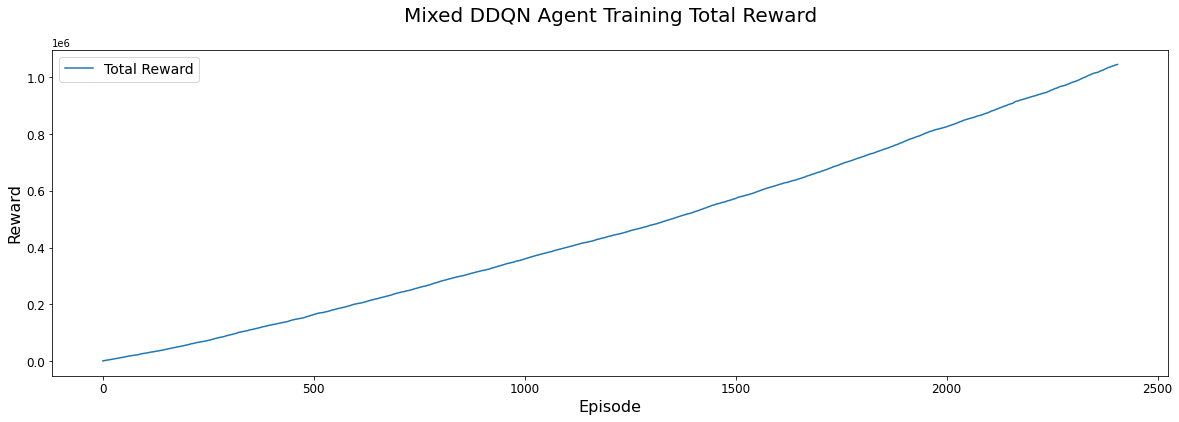

In [6]:
# Plot the training reward cumulative sum throughout the episodes (1 episode = 3 player lives)
plot_df(train_df, 
        cols=['Total Reward'], 
        x_label='Episode', 
        y_label='Reward',
        title='Mixed DDQN Agent Training Total Reward\n')

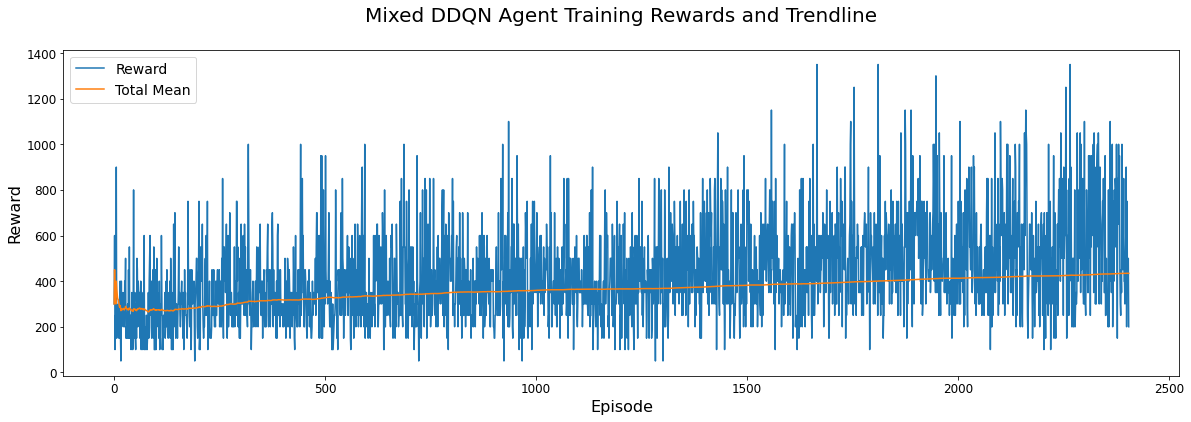

In [7]:
# Plot the training reward values throughout the episodes (1 episode = 3 player lives)
plot_df(train_df, 
        cols=['Reward', 'Total Mean'], 
        x_label='Episode',
        y_label='Reward',
        title='Mixed DDQN Agent Training Rewards and Trendline\n')

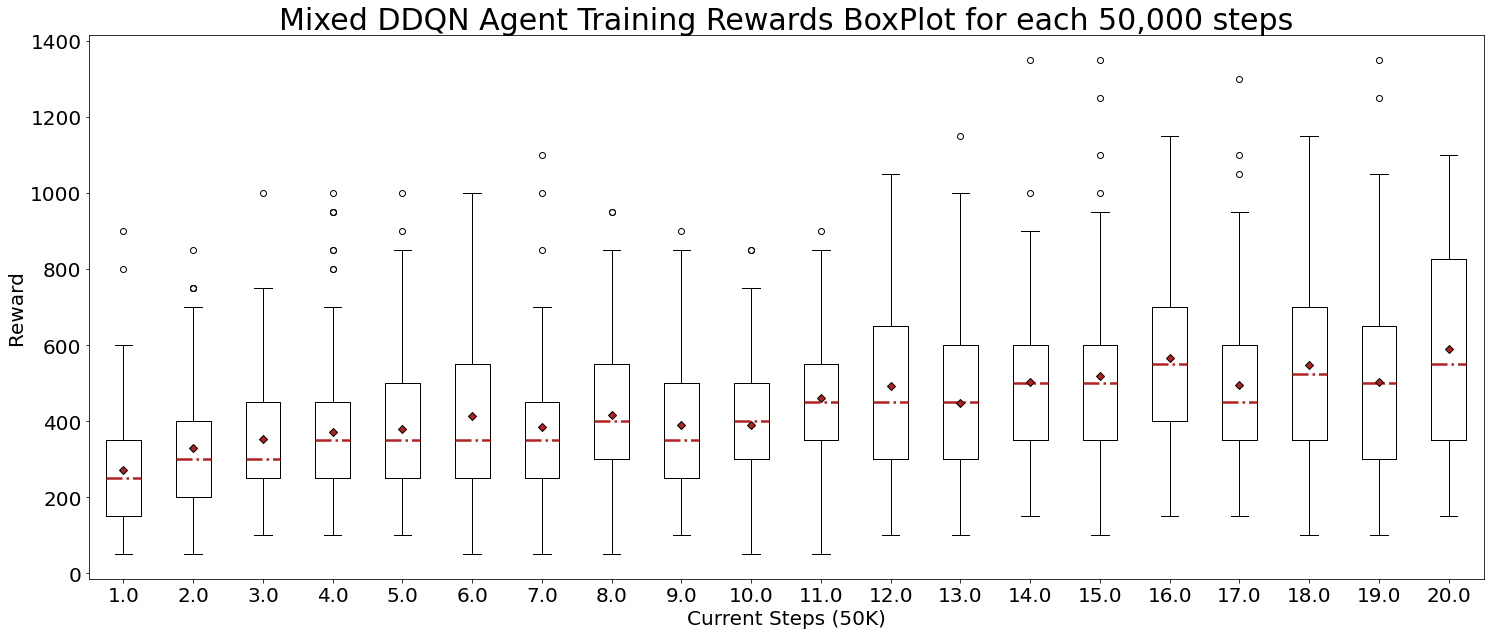

In [8]:
# Display a boxplot of the DDQN agent training data (agent rewards)
plot_boxplot_for_episodes(train_df, 
                          ['Reward'], 
                          ['DDQN-Image'], 
                          x_label='Current Steps (50K)', 
                          y_label='Reward', 
                          title='Mixed DDQN Agent Training Rewards BoxPlot for each 50,000 steps')

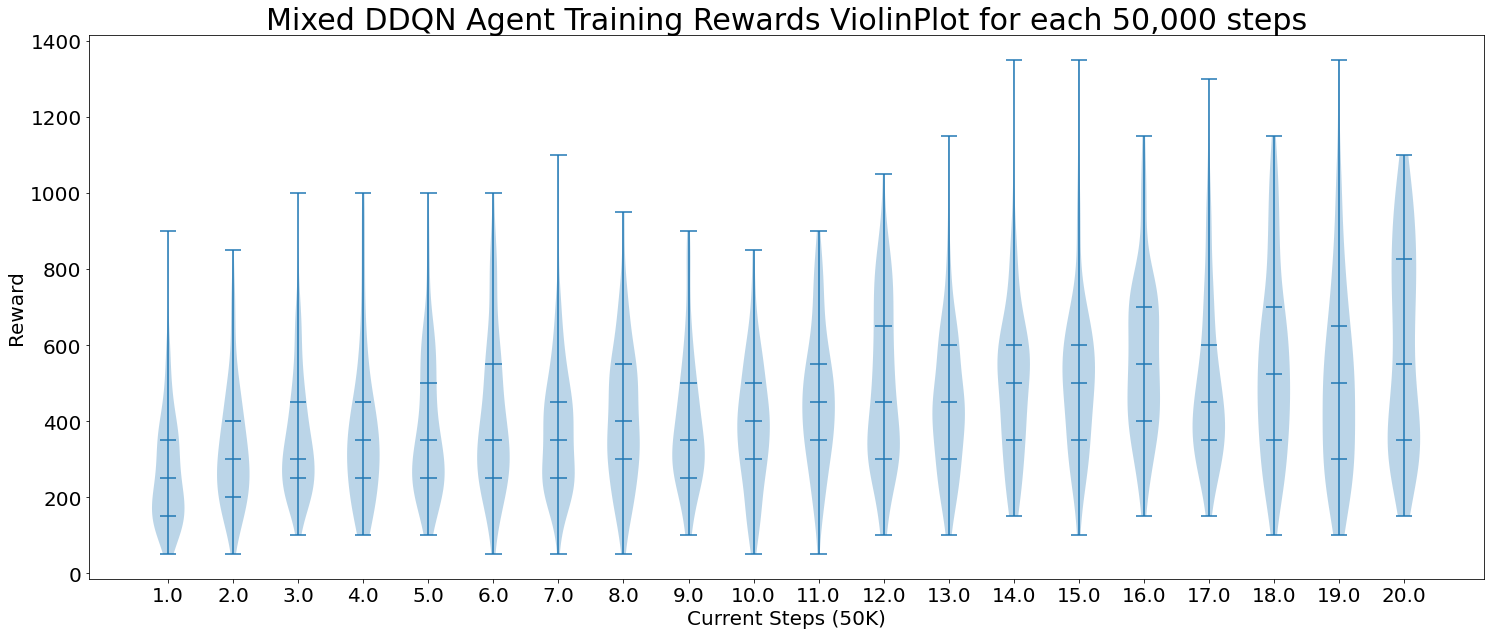

In [9]:
plot_violinplot_for_episodes(train_df, 
                             ['Reward'], 
                             ['DDQN-Image'], 
                             x_label='Current Steps (50K)', 
                             y_label='Reward', 
                             title='Mixed DDQN Agent Training Rewards ViolinPlot for each 50,000 steps')

In [19]:
# Save the obtaine DDQN training data to a CSV file
train_df.to_csv('current_model.csv')

### Architecture

In [20]:
# Create a HDF5 file with the trained online model
# with all the details necessary to reconstitute it. 
ddqn_online = ddqn_agent.online
ddqn_online.save('mixed_ddqn_v2_online_unrendered.h5') 

# Create a HDF5 file with the trained target model
# with all the details necessary to reconstitute it. 
ddqn_target = ddqn_agent.target
ddqn_target.save('mixed_ddqn_v2_target_unrendered.h5')

# Print the mixed DDQN v2 architecture summary
ddqn_online.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 84, 84, 5)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 21, 21, 32)   10272       ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 11, 11, 64)   32832       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 11, 11, 64)   36928       ['conv2d_1[0][0]']               
                                                                                              

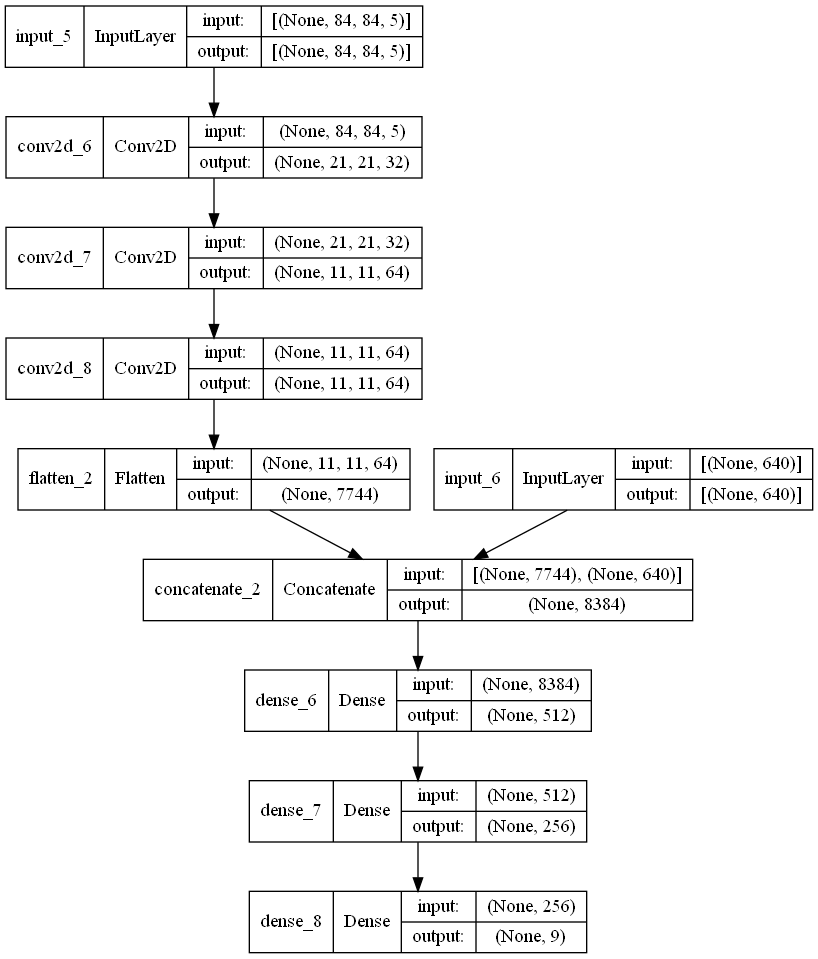

In [18]:
from tensorflow.keras.utils import plot_model

# Plot the mixed input DDQN and save it as a PNG file
plot_model(ddqn_online, to_file="mixed_v2_ddqn.png", show_shapes=True)

## Task 3.3

For the comparison, please refer to Notebook `Plots` in the folder Assessment1 which contains all performed experiments. 